In [ ]:
from keras.models import model_from_json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn as sk
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import *
from keras import callbacks
from keras.utils.np_utils import *

print("Done Loading")


Done Loading


In [ ]:
full_df = pd.read_csv("https://raw.githubusercontent.com/jwaldroop/phishing-url-project/main/dataset_full.csv")

full_df.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,25,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,17,0,0,...,0,0,0,7,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.207316,0,60781,-1,-1,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,0,0,0,0,0,0,0,3,223,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,16,0,0,...,0,0,0,9,0,0,1,0,0,3,0,2,0,0,0,0,0,0,0,0,0,165,0,3,0,0.499566,-1,36024,579,150,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,15,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,14,0,0,...,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.935901,0,4766,-1,-1,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,81,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,19,0,0,...,0,0,0,9,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.410021,0,20454,-1,-1,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,19,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,19,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.410761,0,53831,6998,306,1,2,1,3597,0,1,0,0,0,0


In [ ]:
len(full_df[full_df.phishing == 1])

30647

In [ ]:
len(full_df[full_df.phishing != 1])

58000

# neural network model on entire dataset

In [ ]:
y = full_df.iloc[:,-1]

X = full_df.iloc[:,0:111]

X = tf.keras.utils.normalize(X, axis=-1, order=2)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=808)

train_X.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened
5676,0.000004,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.000042,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000008,0.000038,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,0.0,0.000033,-0.000004,0.999934,0.000591,0.000797,0.000004,0.000023,0.000008,0.011480,0.000004,0.000000,0.0,0.0,0.0
39002,0.000777,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000259,0.003369,0.000777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000518,0.003369,0.0,0.0,...,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,-0.000259,0.0,0.000063,0.000000,0.730208,-0.000259,0.680198,0.001036,0.001036,0.000518,0.064003,0.000259,0.000259,0.0,0.0,0.0
1732,0.000092,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000046,0.000737,0.000092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000230,0.000737,0.0,0.0,...,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,-0.000046,0.0,0.000020,0.000000,0.698307,0.269674,0.016112,0.000046,0.000092,0.000046,0.662860,0.000000,0.000000,0.0,0.0,0.0
39668,0.000122,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000061,0.001588,0.000122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000550,0.001588,0.0,0.0,...,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,-0.000061,0.0,0.000038,0.000000,0.859057,0.261792,0.005926,0.000061,0.000122,0.000244,0.439823,0.000000,0.000061,0.0,0.0,0.0
82035,0.000054,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000027,0.000751,0.000054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000188,0.000751,0.0,0.0,...,-0.000027,-0.000027,-0.000027,-0.000027,-0.000027,-0.000027,-0.000027,-0.000027,-0.000027,-0.000027,-0.000027,-0.000027,-0.000027,-0.000027,-0.000027,-0.000027,-0.000027,-0.000027,-0.000027,-0.000

In [ ]:
tf.keras.backend.clear_session()

#neural net

nn_mod_1 = keras.Sequential([
                          layers.InputLayer(input_shape=[111]),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=50, activation='relu'),
                          layers.Dropout(0.20),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=32, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=16, activation='relu'),
                          layers.Dropout(0.40),
                          layers.Dense(units=111, activation='relu'),
                          layers.Flatten(),
                          layers.Dense(units=1, activation='sigmoid')
])

nn_mod_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), 
             tf.keras.metrics.AUC(),
             ]
)

earlystopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', mode = 'max',
                                       patience = 25, restore_best_weights = True)


nn_mod_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                7168      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3250      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1

In [ ]:
history1 = nn_mod_1.fit(train_X, train_y, validation_split=0.30, batch_size= 15, epochs=500, callbacks = [earlystopping])

Epoch 1/500
3103/3103 [==============================] - 14s 4ms/step - loss: 0.5861 - binary_accuracy: 0.6751 - auc: 0.7047 - val_loss: 0.5245 - val_binary_accuracy: 0.7277 - val_auc: 0.7908
Epoch 2/500
3103/3103 [==============================] - 10s 3ms/step - loss: 0.5252 - binary_accuracy: 0.7328 - auc: 0.7839 - val_loss: 0.4586 - val_binary_accuracy: 0.7962 - val_auc: 0.9195
Epoch 3/500
3103/3103 [==============================] - 10s 3ms/step - loss: 0.3891 - binary_accuracy: 0.8356 - auc: 0.8986 - val_loss: 0.3043 - val_binary_accuracy: 0.8783 - val_auc: 0.9568
Epoch 4/500
3103/3103 [==============================] - 10s 3ms/step - loss: 0.3241 - binary_accuracy: 0.8670 - auc: 0.9276 - val_loss: 0.2573 - val_binary_accuracy: 0.9045 - val_auc: 0.9600
Epoch 5/500
3103/3103 [==============================] - 10s 3ms/step - loss: 0.3115 - binary_accuracy: 0.8688 - auc: 0.9322 - val_loss: 0.2525 - val_binary_accuracy: 0.9140 - val_auc: 0.9665
Epoch 6/500
3103/3103 [=================

In [ ]:
history_df1 = pd.DataFrame(history1.history)

history_df1.describe()

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,0.252761,0.895643,0.953900,0.237416,0.906256,0.967984
std,0.050725,0.029478,0.030297,0.046501,0.025972,0.021104
min,0.222211,0.696083,0.742062,0.199291,0.727715,0.790808
25%,0.232635,0.897543,0.956425,0.216051,0.905984,0.969773
50%,0.238448,0.903328,0.961067,0.227544,0.911687,0.971452
75%,0.252077,0.905117,0.962744,0.239236,0.917189,0.972893
max,0.560523,0.909345,0.966082,0.524491,0.922491,0.975458


In [ ]:
train_acc = nn_mod_1.evaluate(train_X, train_y)
test_acc = nn_mod_1.evaluate(val_X, val_y)

693/693 [==============================] - 1s 2ms/step - loss: 0.2067 - binary_accuracy: 0.9216 - auc: 0.9738


In [ ]:
dict(zip(nn_mod_1.metrics_names, test_acc))

{'auc': 0.97384113073349,
 'binary_accuracy': 0.9216225743293762,
 'loss': 0.20674724876880646}

Minimum validation loss (binary_crossentropy): 0.19929081201553345


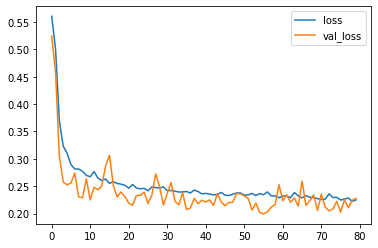

In [ ]:
history_df1.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss (binary_crossentropy): {}".format(history_df1['val_loss'].min()))

Maximum AUC: 0.9754576683044434


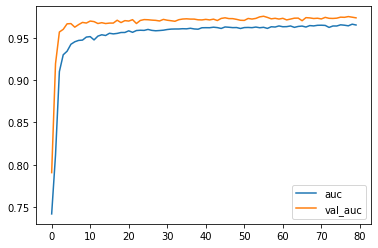

In [ ]:
history_df1.loc[:, ['auc', 'val_auc']].plot();
print("Maximum AUC: {}".format(history_df1['val_auc'].max()))

Maximum validation binary accuracy: 0.9224907159805298


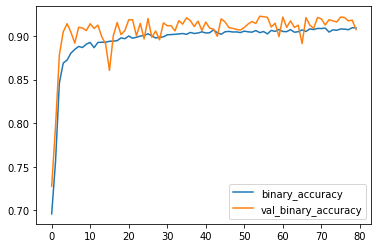

In [ ]:
history_df1.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print("Maximum validation binary accuracy: {}".format(history_df1['val_binary_accuracy'].max()))

In [ ]:
history_df1.binary_accuracy.max() - history_df1.val_binary_accuracy.max()

-0.013145864009857178

In [ ]:
preds1 = nn_mod_1.predict(val_X)
preds1

array([[0.9333241 ],
       [0.0010578 ],
       [0.42017773],
       ...,
       [0.04066953],
       [0.00451577],
       [0.85246253]], dtype=float32)

In [ ]:
len(preds1[preds1 <= 0.5])

13810

In [ ]:
len(preds1[preds1 > 0.5])

8352

In [ ]:
len(val_y)

22162

In [ ]:
preds_df = pd.DataFrame(preds1, columns = ['preds'])

preds_df.head()

,preds
0,0.933324
1,0.001058
2,0.420178
3,0.009585
4,0.543274


In [ ]:
preds_df = pd.concat([preds_df, val_y.reset_index(drop=True), val_X.reset_index()], axis=1)

preds_df

,preds,phishing,index,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,...,qty_asterisk_file,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened
0,0.933324,1,62575,0.000276,0.000000,0.000000,0.000345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000069,0.003517,0.000207,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000345,...,0.000000,0.000000,0.000000,0.000000,0.000690,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,0.0,0.000007,0.000000,-0.000069,0.138820,0.037377,0.000138,0.000138,0.000069,0.989602,0.000000,0.000000,0.0,0.0,0.0
1,0.001058,0,38126,0.000078,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000039,0.001012,0.000078,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000272,...,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,-0.000039,0.0,0.000098,0.000000,0.786588,0.260471,0.009454,0.000039,0.000078,0.000039,0.559770,0.000039,0.000000,0.0,0.0,0.0
2,0.420178,0,1617,0.000138,0.000069,0.000000,0.000069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000069,0.002348,0.000138,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000345,...,0.000000,0.000000,0.000000,0.000000,0.000967,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,-0.000069,0.0,0.000073,-0.000069,0.921059,0.388661,0.014919,0.000138,0.000138,0.000345,0.018994,0.000069,0.000138,0.0,0.0,0.0
3,0.009585,0,8228,0.000041,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000020,0.000285,0.000041,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000020,...,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,-0.000020,0.0,0.000050,0.000020,0.948421,0.119534,0.021672,0.000020,0.000041,0.000020,0.292813,0.000020,0.000020,0.0,0.0,0.0
4,0.543274,1,55594,0.054353,0.000000,0.027176,0.054353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027176,0.760937,0.027176,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108705,...,0.000000,0.000000,0.000000,0.000000,0.271763,-0.027176,-0.027176,-0.027176,-0.027176,-0.027176,-0.027176,-0.027176,-0.027176,-0.027176,-0.027176,-0.027176,-0.027176,-0.02717

In [ ]:
pred_classes = np.argmax(preds1, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_y, pred_classes)
print(cm)

[[14519     0]
 [ 7643     0]]
